# Задачи для экзамена по курсу Численные методы выпуклой оптимизации, осень 2024

Решения задач должны быть выполнены студентом самостоятельно. При обнаружении похожих решений у разных студентов им всем будет поставлен 0 баллов за весь экзамен.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.optimize import minimize
import time

import pandas as pd
import geopandas as gpd

import cvxpy as cp

import sklearn.datasets as skldata
import sklearn.decomposition as skdec
from shapely.geometry import Point
from matplotlib.patches import Circle

(CVXPY) Aug 06 03:09:14 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


## Задача 1 (10 pts)

Пусть дан осциллирующий временой рад $y$, и вам необходимо построить его гладкую аппроксимацию, которая бы отслеживала изменение тренда в этом временном ряду.
Это можно сделать, решив следующую задачу оптимизации

$$ \min_x \| x - y \|^2_2 + \lambda \sum_{i=1}^{n-2} h_{\mu}([Dx]_i), $$

где $D$ - трёхдиагональная матрица с элементами (1, -2, 1) на главных диагоналях, такая что $[Dx]_i = x_i - 2 x_{i+1} + x_{i+2}, 1 \leq i \leq n-2$, функция $h_{\mu}(x) = \begin{cases} x^2 / 2\mu, & |x| \leq \mu \\ |x| - \mu/ 2, & |x| > \mu \end{cases}$ является дифференцируемой и выпуклой. Параметр $\lambda > 0$ задан, параметр $\mu > 0$ также необходимо задать заранее.

__1)__ (1 pts) докажите указанные выше свойства функции $h_{\mu}$

__2)__ (6 pts) сравните метод тяжёлого шарика, ускоренный градиентный метод и квазиньютоновский метод (LBFGS) для решения такой задачи. Значения $y$ можно взять из [файла](https://drive.google.com/file/d/15R9_atkEMiR3l_cOhK-PdvHsj8ecHJso/view?usp=sharing). Постройте графики сходимости и получите время работы каждого из меодов. Протестируйте несколько значений для размера шага в первых двух методах и размера истории в LBFGS. Какой метод оказался наилучшим для решения поставленной задачи и почему?

__3)__ (3 pts) Рассмотрите различные значения параметров $\lambda$ и $\mu$. Прокомментируйте, как их значения влияют на свойства решения.


#### Пункт 1 - свойства функции

![graph](https://downloader.disk.yandex.ru/preview/7fca13fe874ed56f5f725d663cfe47918ffc536b7a310554c6c9b45e153799d2/6782ad4f/QaF65VZ5ivK19h_3j_3qN-kPhxTpJCs9rDro7iCcx_X2LMn8rToq0ZVHjqYWM7OVuIAs1k4TIXlWYOKdWHPt1w%3D%3D?uid=0&filename=h%20graph.jpg&disposition=inline&hash=&limit=0&content_type=image%2Fjpeg&owner_uid=0&tknv=v2&size=2048x2048)



График функции $h_{\mu}(x)$ при  $\mu = 1$ 


Данная функция является сшитыми параболой и двумя линейными кусками. Что парабола, что линейная часть всюду непрерывны и дифференциируемы.
Для проверки дифференциируемости всей функции достаточно проверить стыки.

При $|x| = \mu \quad\ $,     $x^2 / 2\mu = |x| - \mu/ 2 = \mu/2\quad$    и    $\quad(x^2 / 2\mu)' = (|x| - \mu/ 2)' = 1$

При $|x| = -\mu \quad$,    $x^2 / 2\mu = |x| - \mu/ 2 = \mu/2\quad$    и    $\quad(x^2 / 2\mu)' = (|x| - \mu/ 2)' = -1$

Таким образом функция h всюду непрерывна и дифференциируема

Для проверки выпуклости достаточно посмотреть неотрицательность второй производной.
На линейном участке она равна 0, на квадратичном $1/\mu$. Т.о. функция выпукла

#### Пункт 2 - сравнение методов оптимизации

In [2]:
df = pd.read_csv("ibm_data.csv")  
df['Date'] = pd.to_datetime(df['Date'])  
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

dates = df['Date'].values
y = df['Close'].values

print(df.head())
n = len(y)

                        Date     Close
0  1962-01-02 00:00:00-05:00  1.555766
1  1962-01-03 00:00:00-05:00  1.569364
2  1962-01-04 00:00:00-05:00  1.553727
3  1962-01-05 00:00:00-05:00  1.523127
4  1962-01-08 00:00:00-05:00  1.494569


C:\Users\Artem\AppData\Local\Temp\ipykernel_38556\3386360290.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
n

15586

In [4]:
y

array([  1.55576599,   1.56936443,   1.55372655, ..., 155.6499939 ,
       156.41000366, 157.79499817])

In [5]:
diagonal = np.array([1, -2, 1])  
offsets = [0, 1, 2]  
D = diags(diagonal, offsets, shape=(n-2, n)).toarray() 

In [6]:
D

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

In [7]:
def h_mu(x, mu):
    return np.where(np.abs(x) <= mu, x**2 / (2 * mu), np.abs(x) - mu / 2)

def diff_h_mu(x, mu):
    return np.where(np.abs(x) <= mu, x / mu, np.sign(x))

def objective(x, y, D, lam, mu):
    Dx = D @ x  
    return np.linalg.norm(x - y)**2 + lam * np.sum(h_mu(Dx, mu))

def gradient(x, y, D, lam, mu):
    Dx = D @ x  
    grad_h = diff_h_mu(Dx, mu)  
    return 2 * (x - y) + lam * D.T @ grad_h

In [8]:
def heavy_ball_method(y, D, lam, mu, eta, beta, max_iter=1000, tol=1e-6):
    n = len(y)
    x = np.zeros(n)  
    x_prev = np.zeros(n)  
    history = []  
    times = []  
    start_time = time.time()  
    
    for i in range(max_iter):
        grad = gradient(x, y, D, lam, mu)
        x_new = x - eta * grad + beta * (x - x_prev)
        history.append(objective(x, y, D, lam, mu))
        
        times.append(time.time() - start_time)
        
        if np.linalg.norm(x_new - x) < tol:
            break
        
        x_prev = x
        x = x_new
    
    return x, history, times

def accelerated_gradient_method(y, D, lam, mu, eta, beta, max_iter=1000, tol=1e-6):
    n = len(y)
    x = np.zeros(n)
    x_prev = np.zeros(n)
    history = []
    times = []
    start_time = time.time()
    
    for i in range(max_iter):
        y_k = x + beta * (x - x_prev)
        grad = gradient(y_k, y, D, lam, mu)
        x_new = y_k - eta * grad
        history.append(objective(x, y, D, lam, mu))
       
        times.append(time.time() - start_time)
        
        if np.linalg.norm(x_new - x) < tol:
            break
        
        x_prev = x
        x = x_new
    
    return x, history, times

def lbfgs_method(y, D, lam, mu, max_iter=1000, mem_size = 10 ):
    n = len(y)
    history = []
    
    def func(x):
        return objective(x, y, D, lam, mu)
    
    def grad(x):
        return gradient(x, y, D, lam, mu)
    
    def callback(x):
        history.append(func(x))
    
    start_time = time.time()
    result = minimize(func, np.zeros(n), jac=grad, method='L-BFGS-B', options={'maxiter': max_iter, 'maxcor': mem_size}, callback=callback)
    total_time = time.time() - start_time

    nit = result.nit  # Количество итераций
    
    # Временные метки равномерно распределены по числу итераций
    if nit > 0:        
        times = [k * (total_time / nit) for k in range(1, nit + 1)]
    else:       
        times = [0]


    return result.x, history, times


Тестирование параметров

In [9]:
# Параметры
lam = 10.0
mu = 1.0
eta = 0.005  # Шаг градиента
beta = 0.9  # Коэффициент инерции
max_iter = 100

eta_values = [0.0005, 0.0001, 0.005, 0.001]
lbfgs_memory_sizes = [5, 10, 20]

In [10]:
heavy_ball_results = {}
for eta in eta_values:
    x, history, times = heavy_ball_method(y, D, lam, mu, eta, beta, max_iter)
    heavy_ball_results[eta] = (x, history, times)

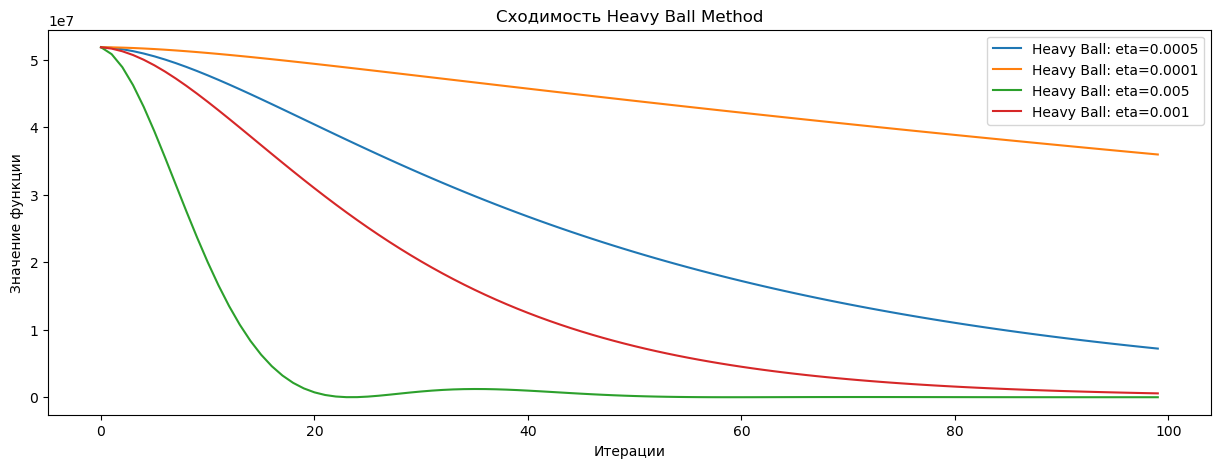

In [11]:
# Графики сходимости для Heavy Ball
plt.figure(figsize=(15, 5))
for eta, (_, history, _) in heavy_ball_results.items():
    plt.plot(history, label=f"Heavy Ball: eta={eta}")
plt.xlabel("Итерации")
plt.ylabel("Значение функции")
plt.legend()
plt.title("Сходимость Heavy Ball Method")
plt.show()

0,005 -- лучшая скорость сходимости

In [12]:
accelerated_gradient_results = {}
for eta in eta_values:
    x, history, times = accelerated_gradient_method(y, D, lam, mu, eta, beta, max_iter)
    accelerated_gradient_results[eta] = (x, history, times)

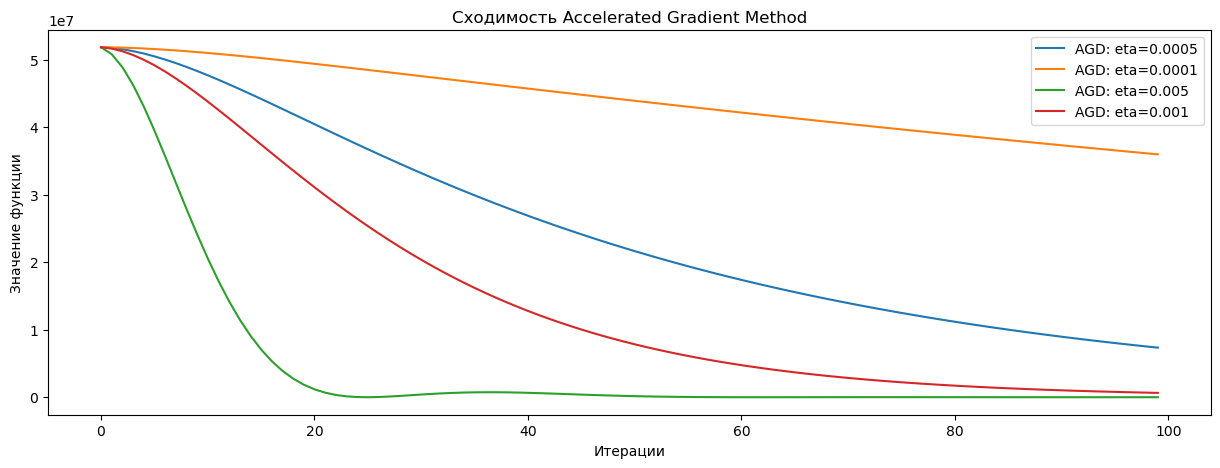

In [13]:
# Графики сходимости для AGD
plt.figure(figsize=(15, 5))
for eta, (_, history, _) in accelerated_gradient_results.items():
    plt.plot(history, label=f"AGD: eta={eta}")
plt.xlabel("Итерации")
plt.ylabel("Значение функции")
plt.legend()
plt.title("Сходимость Accelerated Gradient Method")
plt.show()

Тут тоже 0,005 -- лучшая скорость сходимости

In [14]:
lbfgs_results = {}
for mem_size in lbfgs_memory_sizes:
    x_lbfgs, history_lbfgs, times_lbfgs = lbfgs_method(y, D, lam, mu, max_iter, mem_size)
    lbfgs_results[mem_size] = (x_lbfgs, history_lbfgs, times_lbfgs)


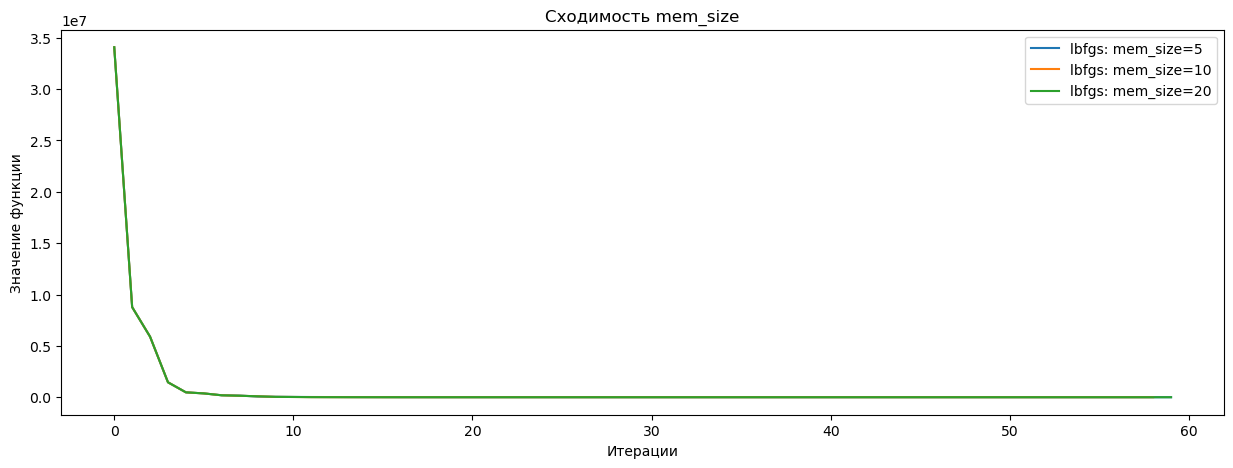

In [15]:
# Графики сходимости для lbfgs
plt.figure(figsize=(15, 5))
for mem_size, (_, history, _) in lbfgs_results.items():
    plt.plot(history, label=f"lbfgs: mem_size={mem_size}")
plt.xlabel("Итерации")
plt.ylabel("Значение функции")
plt.legend()
plt.title("Сходимость mem_size")
plt.show()

In [16]:
# Метод тяжелого шарика
start = time.time()
x_hb, history_hb, times_hb = heavy_ball_method(y, D, lam, mu, eta, beta, max_iter)
time_hb = time.time() - start

In [17]:
# Ускоренный градиентный метод
start = time.time()
x_ag, history_ag, times_ag= accelerated_gradient_method(y, D, lam, mu, eta, beta, max_iter)
time_ag = time.time() - start

In [18]:
# Метод LBFGS
start = time.time()
x_lbfgs, history_lbfgs, times_lbfgs = lbfgs_method(y, D, lam, mu, max_iter)
time_lbfgs = time.time() - start

In [19]:
# # Вывод времени работы
print(f"Heavy Ball: {time_hb:.2f} s")
print(f"Accelerated Gradient: {time_ag:.2f} s")
print(f"LBFGS: {time_lbfgs:.2f} s")

Heavy Ball: 48.74 s
Accelerated Gradient: 50.02 s
LBFGS: 39.02 s


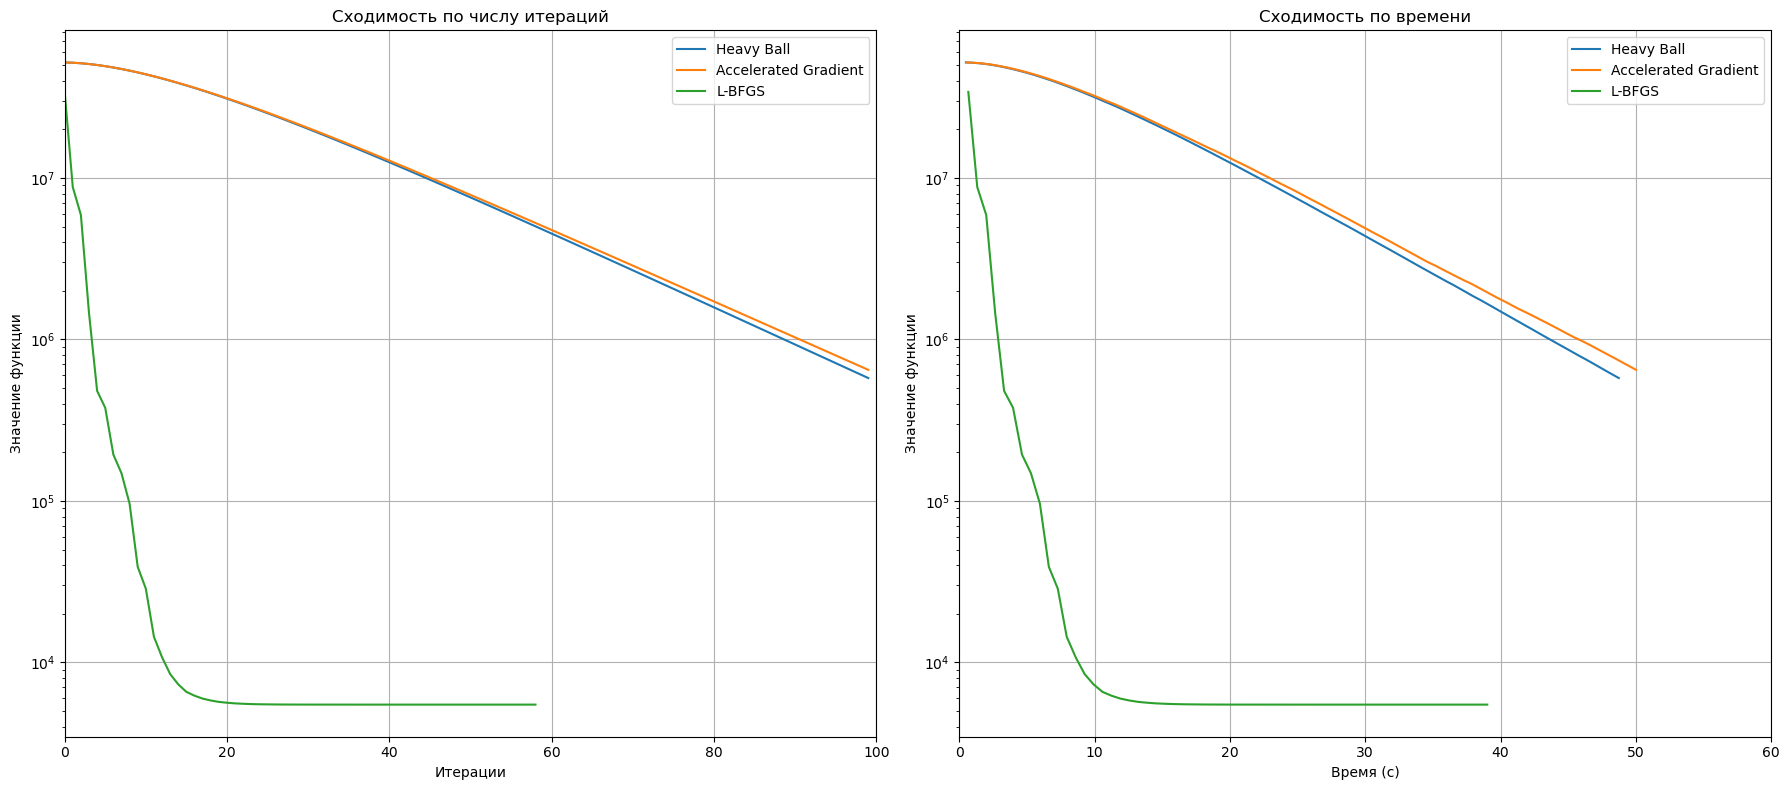

In [20]:
plt.figure(figsize=(18, 8))  

# Сходимость по итерациям
plt.subplot(1, 2, 1)  # Один ряд, два столбца, первая ячейка
plt.plot(history_hb, label="Heavy Ball")
plt.plot(history_ag, label="Accelerated Gradient")
plt.plot(history_lbfgs, label="L-BFGS")
plt.yscale('log') 
plt.xlim(0, 100)   
plt.xlabel("Итерации")
plt.ylabel("Значение функции")
plt.title("Сходимость по числу итераций")
plt.legend()
plt.grid()

# Сходимость по времени
plt.subplot(1, 2, 2)  # Один ряд, два столбца, вторая ячейка
plt.plot(times_hb, history_hb, label="Heavy Ball")
plt.plot(times_ag, history_ag, label="Accelerated Gradient")
plt.plot(times_lbfgs, history_lbfgs, label="L-BFGS")
plt.yscale('log')
plt.xlim(0, 60)   
plt.xlabel("Время (с)")
plt.ylabel("Значение функции")
plt.title("Сходимость по времени")
plt.legend()
plt.grid()

# Отобразить оба графика
plt.tight_layout()
plt.show()

In [21]:
len(y)

15586

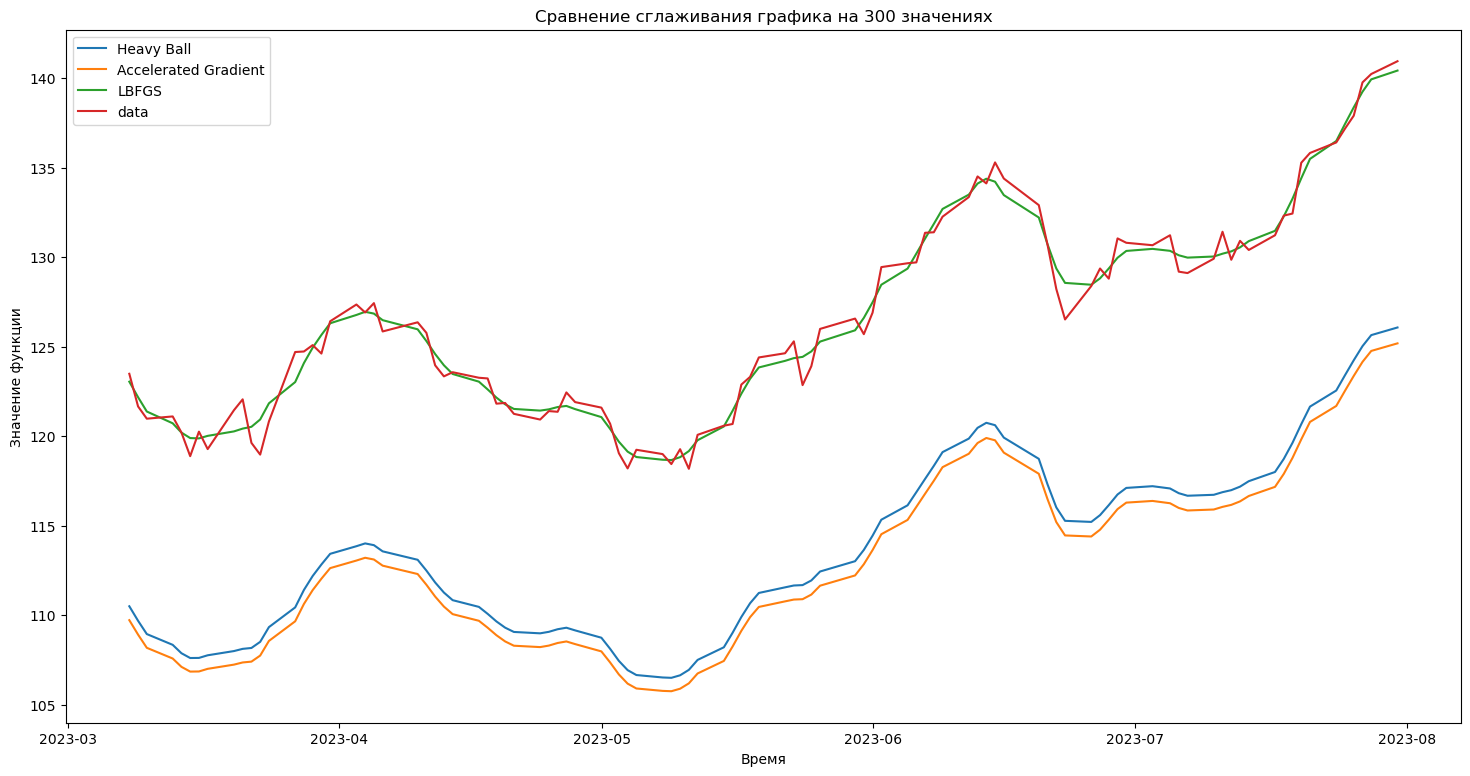

In [22]:
# Графики
start_idx = 15400
end_idx = 15500

dates_subset = dates[start_idx: end_idx]
y_subset = y[start_idx: end_idx]
x_hb_subset = x_hb[start_idx: end_idx]
x_ag_subset = x_ag[start_idx: end_idx]
x_lbfgs_subset = x_lbfgs[start_idx: end_idx]



plt.figure(figsize=(18, 9))
plt.plot(dates_subset, x_hb_subset, label='Heavy Ball')
plt.plot(dates_subset, x_ag_subset, label='Accelerated Gradient')
plt.plot(dates_subset, x_lbfgs_subset, label='LBFGS')
plt.plot(dates_subset, y_subset, label='data')
plt.xlabel('Время')
plt.ylabel('Значение функции')
plt.legend()
plt.title('Сравнение сглаживания графика на 300 значениях')
plt.show()

#### Пункт 3 - Различные значения параметров $\lambda$ и $\mu$.

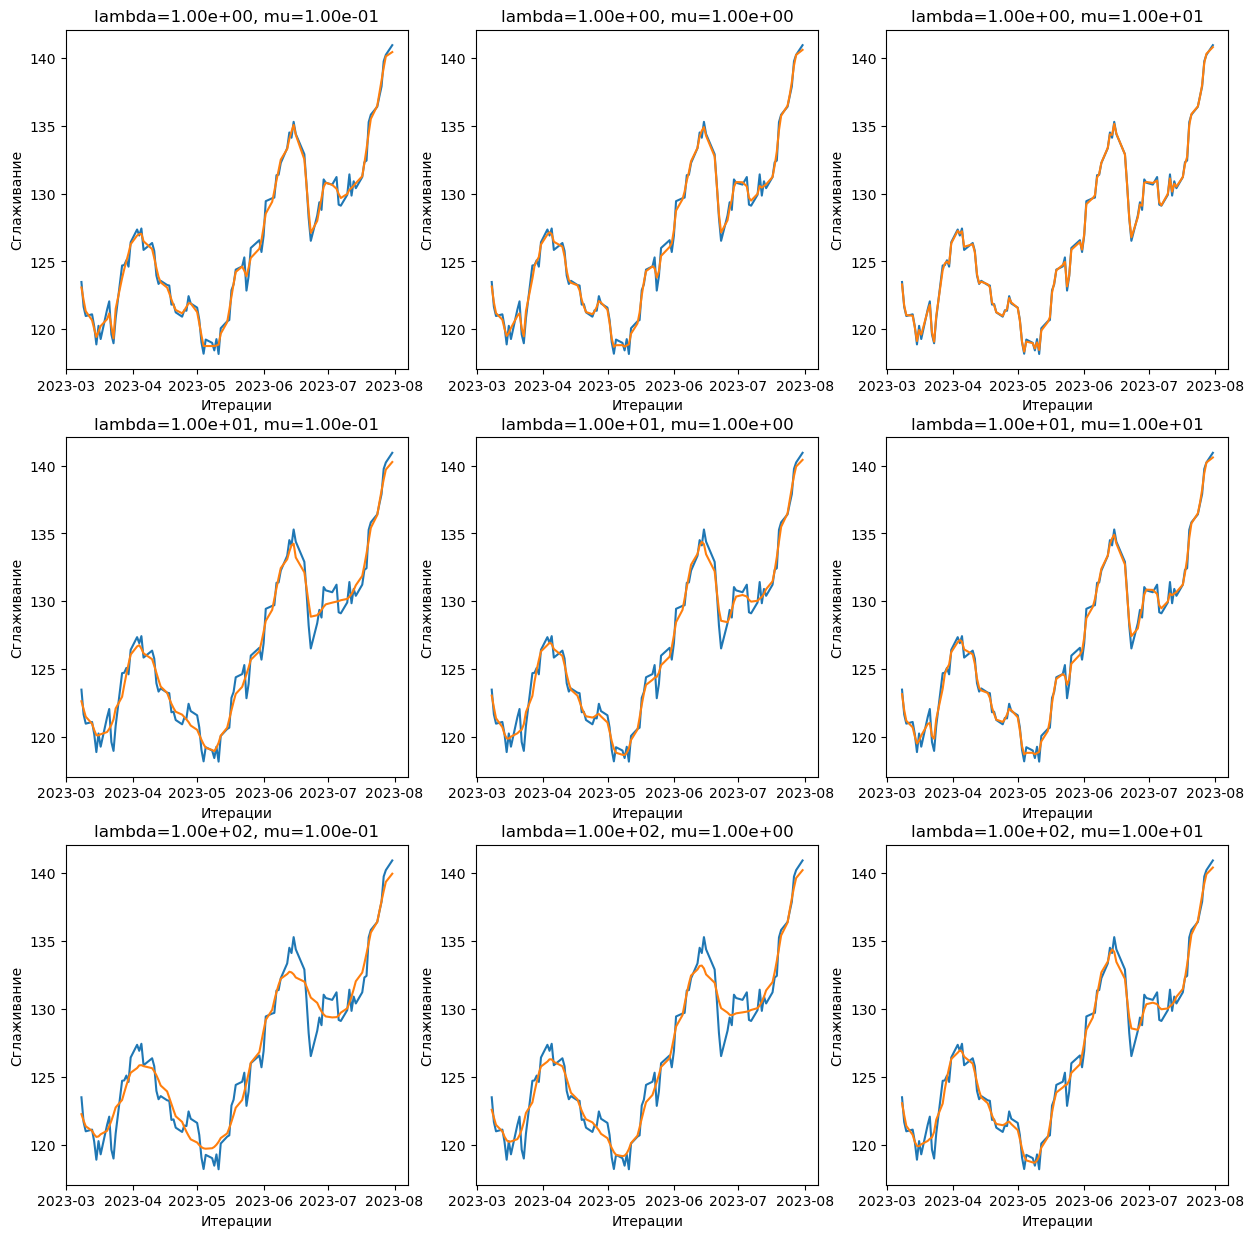

In [23]:
lambda_values = np.logspace(0, 2, 3)  # Шкала от 1 до 100
mu_values = np.logspace(-1, 1, 3)      # Шкала от 0.1 до 10

start_idx = 15400
end_idx = 15500

dates_subset = dates[start_idx: end_idx]

plt.figure(figsize=(15, 15))  
plot_index = 1  


for lam in lambda_values:
    for mu in mu_values:
        # Запускаем lbfgs_method для текущих значений lambda и mu
        x_opt, history, times = lbfgs_method(y, D, lam, mu, max_iter=100)

        x_subset = x_opt[start_idx: end_idx]

        # Рисуем график
        plt.subplot(len(lambda_values), len(mu_values), plot_index)
        plt.plot(dates_subset, y_subset, label='data')
        plt.plot(dates_subset, x_subset, label='smothed')
        plt.title(f"lambda={lam:.2e}, mu={mu:.2e}")
        plt.xlabel("Итерации")
        plt.ylabel("Сглаживание")
        plot_index += 1

Чем больше лямбда, тем сильнгее сглаживание.

При маленьких mu регуляризация становится похожа на l1. При больших на l2.

#### Замечение

Проблема с этими данными в том, что тут явная гетеросхедастичность. Значения и дисперсия в начале и в конце периода оличаются на 2 порядка. 
Из-за этого тренд и сглаживание продуктивнее делать на логарифме данных.

## Задача 2 (6 pts)

Пусть даны два графа $G_A$ и $G_B$ с матрицами смежности $A$ и $B$ соответственно. [Задача об изоморфизме графов](https://en.wikipedia.org/wiki/Graph_isomorphism_problem) состоит в поиске такой матрицы перестановки $P$, что выполнено

$$
PAP^{\top} = B.
$$

На данный момент неизвестно является ли эта задача NP-полной или лежит в классе P.

1) (2 pts) запишите ограничения на искомую матрицу $P$ и покажите, что задача об изоморфизме графа может быть записана как бинарная задачу линейного программирования, то есть как задача линейного программирования, в которой элементами решения могут быть только 0 и 1. Вам необходимо привести целевую функцию в максимально простом виде (чем проще целевая функция, тем быстрее будет работать солвер), ключевое слово min или max, а также допустимое множество. (**Hint**: подумайте как задачу о существовании некоторого элемента в множестве записать в виде задачи оптимизации)

2) (2 pts) далее рассмотрите релаксацию поставленной задачи, в которой элементы решения могут принимать значения в отрезке $[0, 1]$. Если решение такой задачи не нашлось, то это значит, что графы не изоморфны. Если решение нашлось и элементы решения только 0 или 1, то найдена искомая перестановка. Конечно, такое случается достаточно редко. Чтобы форсировать бинарность элементов решения, к целевой функции исходной задачи можно добавить слагаемое вида $\langle W, P \rangle$, где $W$ некоторая случайная матрица, например с элементами из $N(0, 1)$ (возможно использование других распределений). Добавление такого слагаемого не повлияет на решение вопроса существования перестановки.

3) (2 pts) Убедитесь, что графы с матрицами смежности, заданными [тут](https://web.stanford.edu/~boyd/cvxbook/cvxbook_additional_exercises/graph_isomorphism_data.py), являются изоморфными с помощью cvxpy. Для поиска матрицы перестановки, возможно, необходимо решать несколько задач линейного программирования для разных матриц $W$. Также рассмотрите несколько распределений для генерации матрицы $W$. Убедитесь, что найденная матрица действительно является матрицей перестановки. Для проверки бинарности элементов можно отслеживать величину $\max_{(i, j)} P_{ij}(1 - P_{ij})$. После обнаружения матрицы перестановки выведите результат умножения матрицы $P^*$ на вектор $[1, 2, \ldots, n]$ для демонстрации того, как надо переставить вершины исходного графа.

#### Пункт 1 - постановка

Матрица перестановки P -- это квадратная матрица со значениями {0 , 1} в каждой строке и в каждом столбце которой есть ровно по одной единице.

$$
\begin{array}{cl}  
  \sum_{i=1}^n P_{ij} = 1 & \forall j = 1, 2, ..., n \\
  \sum_{j=1}^n P_{ij} = 1 & \forall i = 1, 2, ..., n\\
  P_{ij} \in \{0, 1\}     & \forall i, j = 1, 2, ..., n
\end{array}
$$

Так как P ортонорамированная матрица, для неё $P^{-1} = P^T$, значит, мы можем переписать условие $PAP^{\top} = B$ как $PA = BP$

$$
\begin{array}{cl} 
find & P \\
  s.t. 
  & PA = BP \\
  & \sum_{i=1}^n P_{ij} = 1 & \forall j = 1, 2, ..., n \\
  & \sum_{j=1}^n P_{ij} = 1 & \forall i = 1, 2, ..., n\\
  & P_{ij} \in \{0, 1\}     & \forall i, j = 1, 2, ..., n 
\end{array}
$$

В таком виде это бинарная линейная задача существования.
Можно от задачи существования перейти к задаче минимизации:

$$
\begin{array}{cl} 
min & PA-BP \\
  s.t.   
  & \sum_{i=1}^n P_{ij} = 1 & \forall j = 1, 2, ..., n \\
  & \sum_{j=1}^n P_{ij} = 1 & \forall i = 1, 2, ..., n\\
  & P_{ij} \in \{0, 1\}     & \forall i, j = 1, 2, ..., n 
\end{array}
$$

#### Пункт 2 - релаксация
Релаксация задачи переходам от задачи ЛЦП к задаче ЛП осуществляется заменой $P_{ij} \in \{0, 1\}$ на принадлежность отрезку $[0,1]$. Также для увеличения числа нулей можно добавить $\langle W, P \rangle$ к целевой функции. Итоговая релаксированная задача:

$$
\begin{array}{cl} 
min & PA-BP + \langle W, P \rangle \\
  s.t.   
  & \sum_{i=1}^n P_{ij} = 1 & \forall j = 1, 2, ..., n \\
  & \sum_{j=1}^n P_{ij} = 1 & \forall i = 1, 2, ..., n\\
  & P_{ij} \in [0, 1]     & \forall i, j = 1, 2, ..., n 
\end{array}
$$

#### Пункт 3 - решение солвером

In [24]:
# Матрицы A и B
A = np.array(np.mat(
'0  1  0  0  0  0  1  0  0  0  1  1  1  0  0  1  0  1  1  0  1  1  0  1  0  1  1  1  0  1;\
 1  0  0  0  0  0  1  1  0  0  1  0  1  0  0  1  1  0  0  0  0  0  0  0  1  0  0  1  1  0;\
 0  0  0  1  1  1  0  0  0  0  1  1  0  1  0  1  0  0  0  1  1  0  1  0  1  1  0  1  1  0;\
 0  0  1  0  0  1  0  0  1  0  0  0  1  1  0  0  0  1  1  1  1  0  0  1  0  0  0  1  0  1;\
 0  0  1  0  0  1  0  0  1  1  0  0  0  0  0  1  0  0  1  0  0  0  0  1  1  0  1  0  0  1;\
 0  0  1  1  1  0  0  1  0  1  1  1  1  0  1  0  1  1  1  1  1  1  1  1  1  1  0  1  1  1;\
 1  1  0  0  0  0  0  1  1  0  0  1  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  1  1;\
 0  1  0  0  0  1  1  0  0  1  1  0  0  1  0  1  0  0  1  0  0  1  1  1  0  1  0  1  0  0;\
 0  0  0  1  1  0  1  0  0  1  1  0  0  1  1  1  1  1  1  0  1  0  0  1  0  0  0  1  0  1;\
 0  0  0  0  1  1  0  1  1  0  0  0  1  1  0  1  0  0  0  0  0  1  0  1  0  0  0  0  0  0;\
 1  1  1  0  0  1  0  1  1  0  0  1  0  0  0  0  1  0  0  0  1  1  0  1  0  1  1  1  0  1;\
 1  0  1  0  0  1  1  0  0  0  1  0  0  0  0  0  1  1  0  0  0  0  0  0  1  0  0  1  1  0;\
 1  1  0  1  0  1  0  0  0  1  0  0  0  1  1  1  0  0  0  0  1  0  1  0  1  1  0  1  1  0;\
 0  0  1  1  0  0  0  1  1  1  0  0  1  0  0  1  0  0  1  0  1  0  0  1  0  0  0  1  0  1;\
 0  0  0  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  1  1  0  0  0  1  1  0  1  0  0  1;\
 1  1  1  0  1  0  1  1  1  1  0  0  1  1  1  0  0  1  0  1  1  1  1  1  1  1  0  1  1  1;\
 0  1  0  0  0  1  0  0  1  0  1  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  1  0  1  1;\
 1  0  0  1  0  1  0  0  1  0  0  1  0  0  0  1  1  0  0  1  0  1  1  1  0  1  0  1  0  0;\
 1  0  0  1  1  1  1  1  1  0  0  0  0  1  1  0  1  0  0  1  1  0  0  1  0  0  0  1  0  1;\
 0  0  1  1  0  1  0  0  0  0  0  0  0  0  1  1  0  1  1  0  0  1  0  1  0  0  0  0  0  0;\
 1  0  1  1  0  1  0  0  1  0  1  0  1  1  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  0;\
 1  0  0  0  0  1  1  1  0  1  1  0  0  0  0  1  1  1  0  1  1  0  0  0  0  0  1  1  0  0;\
 0  0  1  0  0  1  0  1  0  0  0  0  1  0  0  1  0  1  0  0  0  0  0  1  1  1  0  0  0  0;\
 1  0  0  1  1  1  0  1  1  1  1  0  0  1  1  1  0  1  1  1  0  0  1  0  0  1  0  0  1  0;\
 0  1  1  0  1  1  0  0  0  0  0  1  1  0  1  1  0  0  0  0  0  0  1  0  0  1  0  0  1  1;\
 1  0  1  0  0  1  0  1  0  0  1  0  1  0  0  1  0  1  0  0  0  0  1  1  1  0  0  1  0  1;\
 1  0  0  0  1  0  1  0  0  0  1  0  0  0  1  0  1  0  0  0  1  1  0  0  0  0  0  1  1  0;\
 1  1  1  1  0  1  0  1  1  0  1  1  1  1  0  1  0  1  1  0  0  1  0  0  0  1  1  0  0  1;\
 0  1  1  0  0  1  1  0  0  0  0  1  1  0  0  1  1  0  0  0  0  0  0  1  1  0  1  0  0  1;\
 1  0  0  1  1  1  1  0  1  0  1  0  0  1  1  1  1  0  1  0  0  0  0  0  1  1  0  1  1  0'))

B = np.array(np.mat(
'0  1  0  1  1  1  1  1  1  1  0  1  1  0  1  1  1  0  1  0  1  1  1  1  1  1  0  1  0  1;\
 1  0  1  0  0  0  1  0  1  0  0  0  0  1  0  1  0  1  1  1  0  0  1  1  1  0  0  1  0  0;\
 0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  1  0  1  0  1  1  0  0  0  0  0  0  1  0  1;\
 1  0  0  0  1  0  0  0  1  0  1  1  0  0  0  1  1  1  1  1  1  1  0  1  0  0  0  1  1  0;\
 1  0  1  1  0  0  0  1  0  0  1  0  0  1  0  0  1  0  1  0  0  1  0  0  0  1  0  0  0  0;\
 1  0  0  0  0  0  1  1  1  1  0  1  1  1  1  0  0  0  1  0  1  0  0  0  0  0  0  1  1  1;\
 1  1  1  0  0  1  0  0  1  0  1  0  1  0  1  1  1  1  0  0  0  1  0  1  0  0  1  1  0  0;\
 1  0  0  0  1  1  0  0  0  1  0  0  1  1  1  0  1  0  0  0  1  0  0  0  0  1  1  0  0  1;\
 1  1  1  1  0  1  1  0  0  0  1  1  0  1  0  0  0  1  0  0  0  0  0  0  0  1  0  0  1  0;\
 1  0  0  0  0  1  0  1  0  0  0  0  1  1  0  0  0  0  0  0  0  1  1  1  0  1  0  0  0  0;\
 0  0  0  1  1  0  1  0  1  0  0  1  0  1  0  1  1  0  0  1  1  1  1  0  1  0  0  1  1  0;\
 1  0  0  1  0  1  0  0  1  0  1  0  0  0  0  0  1  0  1  0  0  1  1  0  0  1  0  1  1  0;\
 1  0  0  0  0  1  1  1  0  1  0  0  0  1  0  0  1  1  0  0  0  1  1  1  0  1  0  1  0  0;\
 0  1  0  0  1  1  0  1  1  1  1  0  1  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1;\
 1  0  0  0  0  1  1  1  0  0  0  0  0  0  0  1  0  1  0  1  0  0  1  0  0  0  0  1  0  1;\
 1  1  1  1  0  0  1  0  0  0  1  0  0  0  1  0  1  0  0  0  0  0  1  0  0  0  1  0  0  1;\
 1  0  0  1  1  0  1  1  0  0  1  1  1  1  0  1  0  1  0  1  1  0  0  0  0  0  0  1  1  1;\
 0  1  1  1  0  0  1  0  1  0  0  0  1  1  1  0  1  0  0  1  0  1  1  0  0  1  1  1  0  0;\
 1  1  0  1  1  1  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0;\
 0  1  1  1  0  0  0  0  0  0  1  0  0  1  1  0  1  1  0  0  0  0  0  1  0  0  1  0  0  1;\
 1  0  1  1  0  1  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0;\
 1  0  0  1  1  0  1  0  0  1  1  1  1  1  0  0  0  1  1  0  1  0  1  1  1  0  0  0  1  1;\
 1  1  0  0  0  0  0  0  0  1  1  1  1  1  1  1  0  1  1  0  0  1  0  0  0  0  0  1  0  0;\
 1  1  0  1  0  0  1  0  0  1  0  0  1  1  0  0  0  0  0  1  0  1  0  0  1  0  1  1  1  0;\
 1  1  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  1  1  0  1  0  1  0  0  1  0;\
 1  0  0  0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  0  0  0  0  0  0  1  0  1  1  1  1;\
 0  0  0  0  0  0  1  1  0  0  0  0  0  1  0  1  0  1  0  1  0  0  0  1  0  1  0  1  0  1;\
 1  1  1  1  0  1  1  0  0  0  1  1  1  1  1  0  1  1  0  0  0  0  1  1  0  1  1  0  1  0;\
 0  0  0  1  0  1  0  0  1  0  1  1  0  1  0  0  1  0  0  0  0  1  0  1  1  1  0  1  0  0;\
 1  0  1  0  0  1  0  1  0  0  0  0  0  1  1  1  1  0  0  1  0  1  0  0  0  1  1  0  0  0'))

In [25]:
n = len(A)
num_attempts = 100
distributions = ['normal', 'uniform', 'exponential']

In [26]:
def solve_isomorphism(A, B, W):
    n = len(A)
    P = cp.Variable((n, n))
    
    objective = cp.Minimize(cp.norm(P@A - B@P, 'fro') + cp.trace(W.T @ P))
    
    # Ограничения
    constraints = [
        cp.sum(P, axis=0) == 1,  # столбцы
        cp.sum(P, axis=1) == 1,  # строки
        0 <= P, P <= 1           # элементы в [0,1]
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return P.value

In [27]:
for dist in distributions:
    print(f"\nПробуем распределение: {dist}")
    
    for i in range(num_attempts):
        # Генерируем W из разных распределений
        if dist == 'normal':
            W = np.random.normal(0, 1, (n,n))
        elif dist == 'uniform':
            W = np.random.uniform(-1, 1, (n,n))
        else:
            W = np.random.exponential(1, (n,n))

        if i % 10 == 9:
            print (f"\n Попытка номер: {i+1}")
            
        P = solve_isomorphism(A, B, W)
        
        # Проверка бинарности
        binary_check = np.max(P * (1 - P))
        
        if binary_check < 1e-5:  # если решение близко к бинарному
            P_rounded = np.round(P)  # округляем до ближайшего целого
            
            # Проверяем свойства перестановки
            is_permutation = (
                np.allclose(P_rounded.sum(axis=0), 1) and 
                np.allclose(P_rounded.sum(axis=1), 1) and 
                np.allclose(P_rounded @ A @ P_rounded.T, B)
            )
            
            if is_permutation:
                print(f"\nНайдена матрица перестановки (попытка {i+1})")
                print(f"Максимальное отклонение от бинарности: {binary_check}")
                
                # Показываем перестановку вершин
                vertex_permutation = P_rounded @ np.arange(1, n+1)
                print("\nПерестановка вершин:")
                print(f"Исходные вершины:  {np.arange(1, n+1)}")
                print(f"Новые позиции:     {vertex_permutation.astype(int)}")
                
                # Проверяем корректность изоморфизма
                error = np.linalg.norm(P_rounded @ A @ P_rounded.T - B)
                print(f"\nОшибка изоморфизма (норма PAP^T - B): {error}")
                
                break


Пробуем распределение: normal

 Попытка номер: 10

 Попытка номер: 20

 Попытка номер: 30

 Попытка номер: 40

 Попытка номер: 50

 Попытка номер: 60

 Попытка номер: 70

 Попытка номер: 80

 Попытка номер: 90

 Попытка номер: 100

Пробуем распределение: uniform

 Попытка номер: 10

 Попытка номер: 20

 Попытка номер: 30

 Попытка номер: 40

 Попытка номер: 50

 Попытка номер: 60

 Попытка номер: 70

 Попытка номер: 80

 Попытка номер: 90

 Попытка номер: 100

Пробуем распределение: exponential

 Попытка номер: 10

 Попытка номер: 20

 Попытка номер: 30

 Попытка номер: 40

 Попытка номер: 50

 Попытка номер: 60

 Попытка номер: 70

 Попытка номер: 80

 Попытка номер: 90

 Попытка номер: 100


---

## Задача 3 (10 pts)

__1.__ Скачайте с помощью кода, приведённого ниже, набор фотографий и нарисуйте какую-нибудь из них.

In [28]:

%matplotlib inline
data = skldata.fetch_olivetti_faces()
import numpy as np
print("Shape of data = {}".format(data["images"].shape))
index = 73
plt.imshow(data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

Shape of data = (400, 64, 64)


__2.__ Одним из способов обработки изображений, например для выделения наиболее важных сегментов используется метод неотрицательной матричной факторизации ([Nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf)).
Идея в том, чтобы решить следующую задачу

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

где знак $\geq$ означает покомпонентное сравнение.
Также матрицы $W$ и $H$ малого ранга, то есть $W \in \mathbb{R}^{m \times k}$ и $H \in \mathbb{R}^{k \times n}$, где $k$ - параметр, который необходимо настраивать.
Чем больше $k$, тем точнее приближение, но и тем дольше будет решаться задача.
Матрица $X \in \mathbb{R}^{m \times n}$, где $m$ - это число фото в нашем наборе, а $n$ - это количество пикселей в каждой картинке, то есть каждая строка матрицы $X$ - это векторизованная картинка.

**Вопросы**

1) (1 pts) является ли эта задача выпуклой и почему?

2) (1 pts) как можно интерпретировать факторы $W$ и $H$ и почему важна их покомпонентная неотрицательность?

3) (6 pts) примените проксимальный градиентный метод и его ускоренную версию для поиска локального минимума поставленной задачи, нарисуйте графики сходимости и прокомментируйте результаты. Если на всех данных метод работает долго, выберете некоторое количество достаточно разнообразных фото, чтобы свойства результата сохранились.

4) (1 pts) поскольку размерность $H$ - $k \times n$, то каждую строку $H$ можно преобразовать в картинку аналогично тому, как были собраны строки матрицы $X$. Нарисуйте 10-50 картинок полученных из строк матрицы $H$. Что Вы заметили и как это соотносится с ответами на вопрос 2) предыдущего пункта? Используйте ```plt.colorbar()``` и цветовую схему ```plt.cm.Greys``` для более чёткого отображения значений пикселей

5) (1 pts) Нарисуйте матрицу $W$ с помощью функции ```plt.imshow``` или ```plt.spy```. Насколько сильно она заполнена и почему?

#### Пункт 1 - Выпуклость
Задача не выпукла. Если бы W или H были фиксированы, задача была бы выпуклой, но произведение 2х переменных таким уже не является.

#### Пункт 2 - Интерпретация
Матрицу H можно трактовать как некий скрытый фактор, паттерн, деталь участвующая в формировании больших картинок, а матрицу W - как количество/активацию этих деталей в каждой из картинок.

Покомпонентная неотрицательность важна для этой интерпретации, она позволяет раскладывать картинку на сумму базовых элементов.

Также допущение отрицательных весов многократно усиливает проблему мультиколлинеарности/переобучения. Если у нас есть 2 похожих детали, то можно до бесконечности увеличивать коэффициенты при одной и уменьшать при другой детали, без вреда для значения оптимизируемой функции. Такое поведение является ухудшает как качество решения задачи, так и его интерпретируемость. 

In [29]:
#### Пункт 3 - Проксимальный градиентный спуск


In [30]:
# Место для вашего решения

n_samples = 400
k = 30 

X = data.images[:n_samples].reshape(n_samples, -1)
X.shape

(400, 4096)

In [31]:
def projection_positive(X):
    # Проекция на неотрицательный ортант
    return np.maximum(X, 0)

def objective(X, W, H):
    # Целевая функция
    return 0.5 * np.linalg.norm(X - W @ H, 'fro')**2

def proximal_gradient(X, k, max_iter=100, lr=1e-4):
    m, n = X.shape
    # Инициализация 
    W = np.random.rand(m, k)
    H = np.random.rand(k, n)
    
    obj_history = []
    
    for iter in range(max_iter):
        
        grad_W = (W @ H - X) @ H.T
        grad_H = W.T @ (W @ H - X)
        
        W = projection_positive(W - lr * grad_W)
        H = projection_positive(H - lr * grad_H)        
       
        obj_history.append(objective(X, W, H))
    
    return W, H, obj_history

def accelerated_proximal_gradient(X, k, max_iter=100, lr=1e-4):
    m, n = X.shape
    # Инициализация
    W = np.random.rand(m, k)
    H = np.random.rand(k, n)
    W_prev = W.copy()
    H_prev = H.copy()
    t = 1
    
    obj_history = []
    
    for iter in range(max_iter):
        t_next = (1 + np.sqrt(1 + 4 * t**2)) / 2
        
        # Экстраполяция
        W_ext = W + ((t - 1) / t_next) * (W - W_prev)
        H_ext = H + ((t - 1) / t_next) * (H - H_prev)
        
        # Сохранение текущих значений
        W_prev = W.copy()
        H_prev = H.copy()
        
        # Градиенты
        grad_W = (W_ext @ H_ext - X) @ H_ext.T
        grad_H = W_ext.T @ (W_ext @ H_ext - X)
        
        # Обновление с проекцией
        W = projection_positive(W_ext - lr * grad_W)
        H = projection_positive(H_ext - lr * grad_H)
        
        t = t_next
        
        obj_history.append(objective(X, W, H))
    
    return W, H, obj_history


In [32]:
# Обычный проксимальный градиентный метод
W1, H1, hist1 = proximal_gradient(X, k, max_iter=200, lr=5e-6)

# Ускоренный проксимальный градиентный метод
W2, H2, hist2 = accelerated_proximal_gradient(X, k, max_iter=200, lr=5e-6)

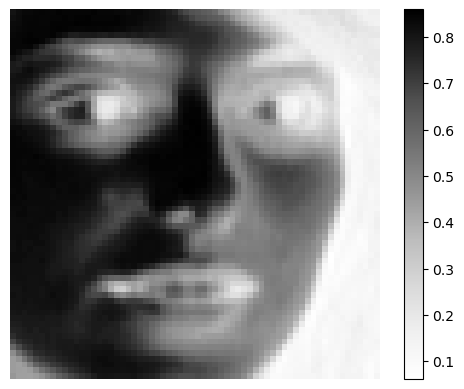

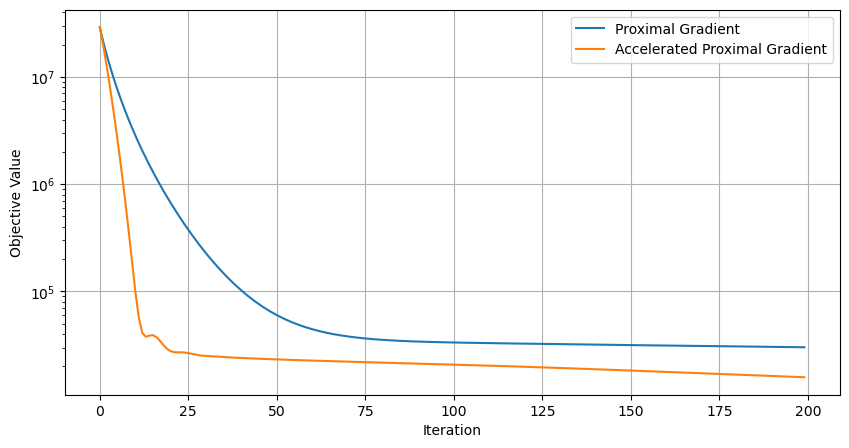

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(hist1, label='Proximal Gradient')
plt.plot(hist2, label='Accelerated Proximal Gradient')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.legend()
plt.grid(True)
plt.show()

Ускоренный спуск показал себя гораздо лучше. Он не только гораздо быстрее сошёлся, но и достиг лучшего локального минимума

#### Пункт 4 - Картинки из H




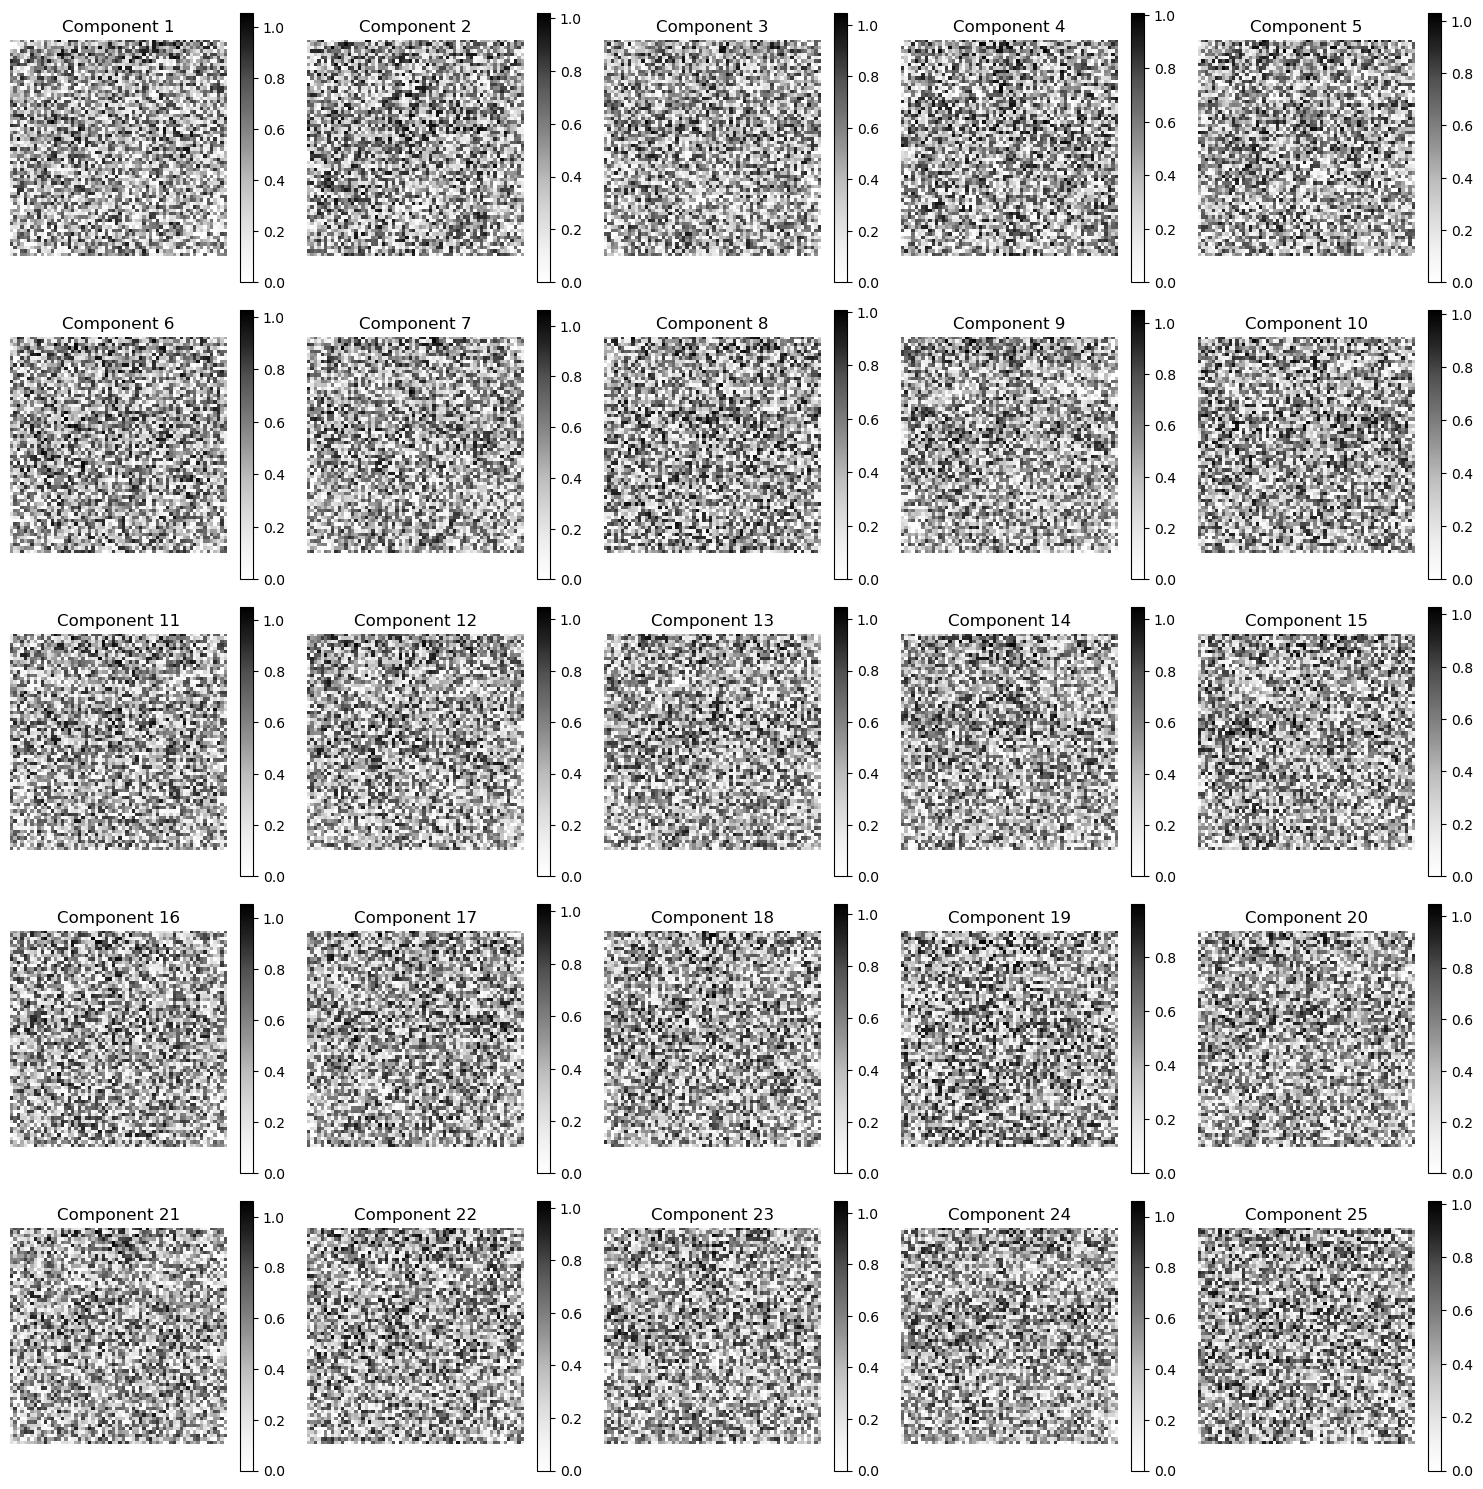

In [34]:
def plot_H_components(H, n_rows=5, n_cols=5):
    plt.figure(figsize=(15, 15))
    for i in range(H.shape[0]):
        if i >= n_rows * n_cols:
            break
        plt.subplot(n_rows, n_cols, i + 1)
        # Преобразуем строку H обратно в форму изображения (64x64)
        component = H[i].reshape(64, 64)
        plt.imshow(component, cmap=plt.cm.Greys)
        plt.colorbar()
        plt.axis('off')
        plt.title(f'Component {i+1}')
    plt.tight_layout()
    plt.show()

plot_H_components(H2)

#### Пункт 5 - Визуализация W


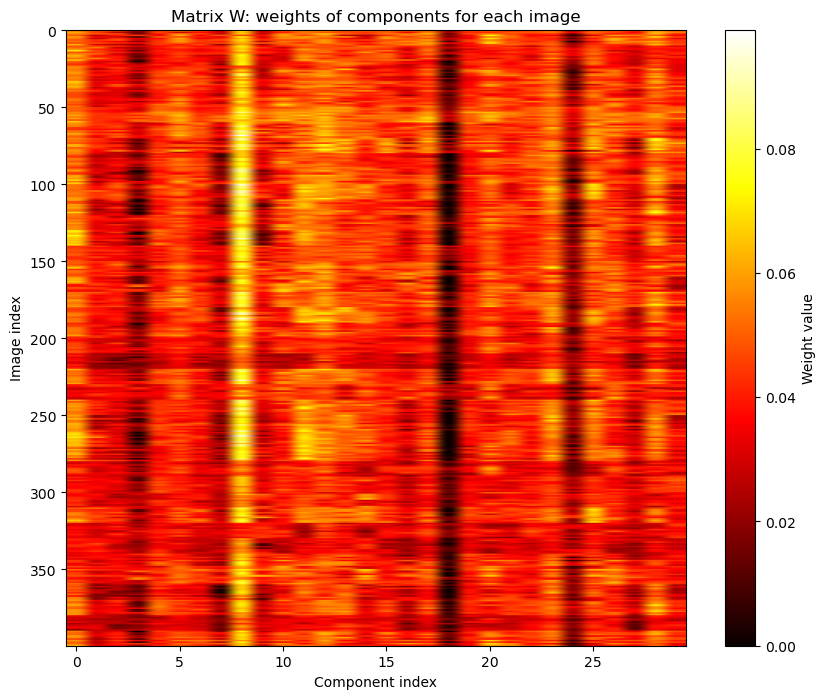

In [35]:
def plot_W_matrix(W):
    plt.figure(figsize=(10, 8))
    plt.imshow(W, cmap='hot', aspect='auto')
    plt.colorbar(label='Weight value')
    plt.xlabel('Component index')
    plt.ylabel('Image index')
    plt.title('Matrix W: weights of components for each image')
    plt.show()

plot_W_matrix(W2)     

Матрица довольно плотно заполнена. Большинство лиц имеет большинство компонент. Чётко видно горизонтальные и вертикальные полосы. Горизонтальные соответствуют картинкам. Видимо, более яркие картинки имеют больше суммарный вес компонент. Видно и вертикальные полосы -- некоторые компоненты используются намного больше других.

---

## Задача 4 (10 pts)

- (3 pts) Градостроитель хотел бы выбрать местоположение $x \in \mathbb{R}^2$ для нового склада.
Оно должно быть близко к $n$ распределительным центрам, расположенным в $y_1, \ldots, y_n \in \mathbb{R}^2$.
Целевая функция для определения местоположения нового склада — это самое большое расстояние до распределительного центра.
Сформулируйте задачу выпуклой оптимизации, которая помогает определить правильное местоположение и докажите, что она является таковой.

- (3 pts) Используйте CVXPy для решения поставленной задачи. Данные для $y_i$ представлены ниже и взяты из набора данных с открытым исходным кодом о местоположении точек спроса в Сан-Франциско. Подробнее см. [здесь](https://github.com/huanfachen/Open_source_location_cover_models/tree/master).
Используйте координаты $y_i$ из переменной ```target_demand_points``` для определения координат $y_i$. Нанесите полученное оптимальное положение для склада на тот же график, что и точки спроса.

In [36]:
# !pip install geopandas

In [37]:
process = lambda df: as_gdf(df).sort_values(by=["NAME"]).reset_index(drop=True)
as_gdf = lambda df: gpd.GeoDataFrame(df, geometry=pnts(df))
pnts = lambda df: gpd.points_from_xy(df.long, df.lat)

def plot_results_on_map(study_area, clis):
    clis = process(clis.copy())
    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 40
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    gdf = gpd.GeoDataFrame(clis["geometry"])
    zorder = 4
    gdf.plot(ax=ax, zorder=zorder, ec="k", markersize=markersize)

In [38]:
map_area = gpd.read_file('ServiceAreas_4.shp').dissolve()

demand_points = pd.read_csv('SF_demand_205_centroid_uniform_weight.csv')
n_dem_pnts = demand_points.shape[0]
demand_points.head()
# Your solution is here

,Unnamed: 0,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
0,1,1,6081602900,60816029.0,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
1,2,2,6081602800,60816028.0,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
2,3,3,6081601700,60816017.0,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
3,4,4,6081601900,60816019.0,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
4,5,5,6081602500,60816025.0,California,0.46603,5146,1459,1467,44,-122.451187,37.640219


In [39]:
# Extract some part of demand points
target_demand_points = demand_points[:30]

In [40]:
plot_results_on_map(map_area, clis=target_demand_points)

In [41]:
# Место для вашего решения

#### Пункт 1 - постановка задачи

Изначально поставленная задача выглядит так:

$$
\min_{x \in \mathbb{R}^2} \quad \max_{i=1,\ldots,n} \|x - y_i\|_2.
$$

От максимума можно избавиться введя дополнительную переменную r, обозначающую максимальное расстояние до склада.

$$
\begin{aligned}
\text{min } & \quad r, \\
\text{s.t. } & \quad \|x - y_i\|_2 \leq r \quad \forall i=1,\ldots,n.
\end{aligned}
$$

Это задача выпуклой оптимизации. Минимизируемая фукнция линейная, т.е. выпуклая. 
Норма тоже явяется выпуклой функцией. Получается у нас в неравествах выпуклая + линейная функция меньше 0. Т.е. сумма выпуклых фукнций, а значит тоже выпуклая. 


#### Пункт 2 - решение через cvxpy

In [42]:
n = target_demand_points.shape[0]
coordinates = target_demand_points[['lat', 'long']].to_numpy()

In [43]:
# Переменные
x = cp.Variable(2) 
r = cp.Variable() 

# Ограничения
constraints = [cp.norm(x - coordinates[i], 2) <= r for i in range(n)]

# Целевая функция
obj = cp.Minimize(r)

# Задача оптимизации
prob = cp.Problem(obj, constraints)
prob.solve()

# Результаты
optimal_location = x.value
optimal_radius = r.value


In [44]:
print("Оптимальное местоположение склада:", optimal_location)
print("Минимальное максимальное расстояние (радиус):", optimal_radius)

Оптимальное местоположение склада: [  37.71618546 -122.46257625]
Минимальное максимальное расстояние (радиус): 0.07827006601130553


In [45]:
def plot_results_on_map(study_area, clis, warehouse_gdf):
    clis = process(clis.copy())
   
    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 40

    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)

    clis_gdf = gpd.GeoDataFrame(clis["geometry"])
    clis_gdf.plot(ax=ax, zorder=4, ec="k", markersize=markersize, color="blue", label="Centers")

    warehouse_gdf.plot(
        ax=ax, 
        zorder=5,  
        color="red",  
        markersize=100, 
        label="Warehouse"
    )

    ax.legend()


warehouse_data = pd.DataFrame({"lat": [optimal_location[0]], "long": [optimal_location[1]]})  # Создаем DataFrame
warehouse_gdf = gpd.GeoDataFrame(
    warehouse_data, geometry=gpd.points_from_xy(warehouse_data.long, warehouse_data.lat))

In [46]:
plot_results_on_map(map_area, clis=target_demand_points, warehouse_gdf=warehouse_gdf )

- (4 pts) Визуализация координат распределительных центров показывает, что на самом деле у нас есть две группы центров, которые должны обслуживаться двумя разными складами.
Переформулируйте исходную задачу таким образом, чтобы её решение определяло позиции двух складов и автоматически назначала каждуый центр целевому складу. Введите новые переменные, если необходимо, и попробуйте решить её с помощью CVXPy. Чтобы сделать задачу подходящей для CVXPy, вы можете выбрать способ измерения расстояний такой, что итоговая задача станет задачей из класса смешанного целочисленного линейного программирования.

#### Пункт 2 - два склада

**Переменные**:
- $x_1$ и $x_2 \in \mathbb{R}^2$: координаты первого и второго склада.
- $z_{i1}, z_{i2} \in \{0, 1\}$: бинарные индикаторы, обозначающие, к какому складу (1 или 2) назначен центр $y_i$. Здесь $z_{i1} = 1$ означает, что $y_i$ присвоен первому складу, а $z_{i2} = 1$ — второму складу.
- $r$: максимальное расстояние от центров $y_i$ до их назначенных складов.

**Ограничения**
   - Все $y_i$ должны быть назначены либо первому, либо второму складу:
     $
     z_{i1} + z_{i2} = 1, \quad \forall i \in \{1, \ldots, n\}.
     $
   - Если $z_{i1} = 1$, то $y_i$ присваивается $x_1$, и расстояние $ \|x_1 - y_i\|_2 \leq r $. Аналогично для $z_{i2}$.
     Используя линейную релаксацию (для CVXPY),
     $
     \|x_1 - y_i\|_2 \leq r + M(1 - z_{i1}),
     $
     где $M$ — большое положительное число, которое "выключает" это ограничение, если $z_{i1} = 0$. Аналогично для $x_2$:
     $
     \|x_2 - y_i\|_2 \leq r + M(1 - z_{i2}).
     $


Задача записывается как:

$$
\begin{array}{rll}
\text{min: } & r \\
\text{s.t.: }  

&z_{i1} + z_{i2} = 1, & \forall i = 1, \ldots, n, \\
&\|x_1 - y_i\|_2 \leq r + M(1 - z_{i1}), & \forall i, \\
&\|x_2 - y_i\|_2 \leq r + M(1 - z_{i2}), & \forall i, \\
&z_{i1}, z_{i2} \in \{0, 1\}, & \forall i.

\end{array}
$$



In [47]:
# pip install "cvxpy[GUROBI]"

In [48]:
print(cp.installed_solvers())

(CVXPY) Aug 06 03:41:49 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
['CLARABEL', 'ECOS', 'ECOS_BB', 'SCIPY', 'SCS']


In [49]:
M = 10

# Переменные
x1 = cp.Variable(2)
x2 = cp.Variable(2)
z = cp.Variable((n, 2), boolean=True)
r = cp.Variable() 

# Ограничения
constraints = []

for i in range(n):
    constraints.append(z[i, 0] + z[i, 1] == 1)

for i in range(n):
    constraints.append(cp.norm(x1 - coordinates[i], 2) <= r + M * (1 - z[i, 0]))
    constraints.append(cp.norm(x2 - coordinates[i], 2) <= r + M * (1 - z[i, 1]))

# Целевая функция
obj = cp.Minimize(r)

# Задача оптимизации
prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.ECOS_BB, verbose=True)

# Результаты
optimal_x1 = x1.value
optimal_x2 = x2.value
optimal_r = r.value
z_value = z.value

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Aug 06 03:41:49 PM: Your problem has 65 variables, 90 constraints, and 0 parameters.
(CVXPY) Aug 06 03:41:49 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 06 03:41:49 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 06 03:41:49 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 06 03:41:49 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 06 03:41:49 PM: Compiling problem (target solver=ECOS_BB).


c:\Users\Artem\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [50]:
print("Оптимальное местоположение склада 1:", optimal_x1)
print("Оптимальное местоположение склада 2:", optimal_x2)
print("Минимальное максимальное расстояние:", optimal_r)

Оптимальное местоположение склада 1: [  37.66810311 -122.44925708]
Оптимальное местоположение склада 2: [  37.74948159 -122.49759199]
Минимальное максимальное расстояние: 0.04302550691339718


In [51]:
def plot_results_on_map_2(study_area, clis, warehouses_gdf, z_value, r):

    import numpy as np

  
   
    # Проходим по каждому центру и определяем, к какому складу он относится
    clis = process(clis.copy()) # Создаём копию, чтобы не модифицировать переданный датафрейм
    clis['warehouse_id'] = np.argmax(z_value, axis=1) + 1  # 1 для склада 1, 2 для склада 2 (вместо индексирования от 0)

    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 40

    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)

    # print (clis)

    # Отображаем центры, относящиеся к первому складу
    clis_warehouse_1 = clis[clis['warehouse_id'] == 1]  # Центры 1-го склада
    clis_warehouse_1_gdf = gpd.GeoDataFrame(clis_warehouse_1, geometry=clis_warehouse_1["geometry"])
    clis_warehouse_1_gdf.plot(
        ax=ax,
        zorder=4,
        ec="k",  
        color="blue",  # Синие точки для 1-го склада
        markersize=markersize,
        label="Centers (Warehouse 1)"
    )

    # Отображаем центры, относящиеся ко второму складу
    clis_warehouse_2 = clis[clis['warehouse_id'] == 2]  # Центры 2-го склада
    clis_warehouse_2_gdf = gpd.GeoDataFrame(clis_warehouse_2, geometry=clis_warehouse_2["geometry"])
    clis_warehouse_2_gdf.plot(
        ax=ax,
        zorder=4,
        ec="k",  
        color="green",  # Зеленые точки для 2-го склада
        markersize=markersize,
        label="Centers (Warehouse 2)"
    )

    # Первый склад
    warehouse_1 = warehouses_gdf.iloc[0:1]  # Данные первого склада
    warehouse_1.plot(
        ax=ax,
        zorder=5,
        color="red",  # Красный склад
        markersize=150,  # Размер маркера увеличен
        label="Warehouse 1"
    )

    # Второй склад
    warehouse_2 = warehouses_gdf.iloc[1:2]  # Данные второго склада
    warehouse_2.plot(
        ax=ax,
        zorder=5,
        color="orange",  # Оранжевый склад
        markersize=150,  # Размер маркера увеличен
        label="Warehouse 2"
    )


    # окружности
    for _, warehouse in warehouses_gdf.iterrows():
        
        center_x, center_y = warehouse.geometry.x, warehouse.geometry.y
        
        
        ax.add_patch(Circle(
            (center_x, center_y),
            radius=r,  # Преобразуем км в градусы широты в приближении
            color='gray',
            alpha=0.2,
            zorder=2,
            label=f"Radius"
        ))



    ax.legend()
    plt.show()

In [52]:
warehouses_data = pd.DataFrame({
    "lat": [optimal_x1[0], optimal_x2[0]],  
    "long": [optimal_x1[1], optimal_x2[1]],
    "warehouse_id": [1, 2]  
})  


warehouses_gdf = gpd.GeoDataFrame(
    warehouses_data,
    geometry=gpd.points_from_xy(warehouses_data.long, warehouses_data.lat)
)

In [53]:
warehouses_data

,lat,long,warehouse_id
0,37.668103,-122.449257,1
1,37.749482,-122.497592,2


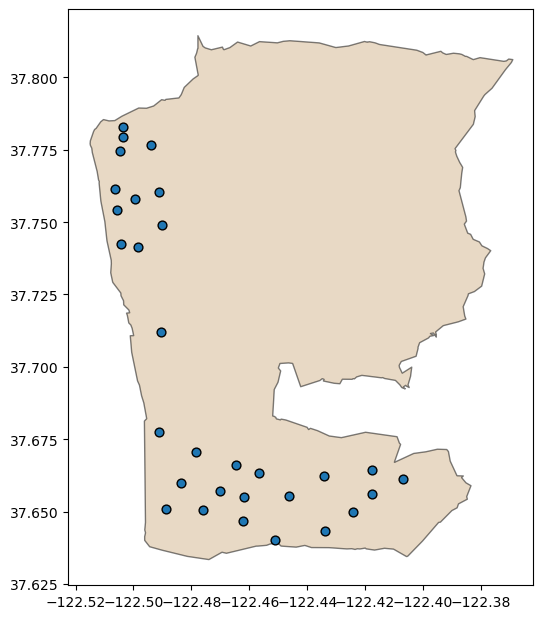

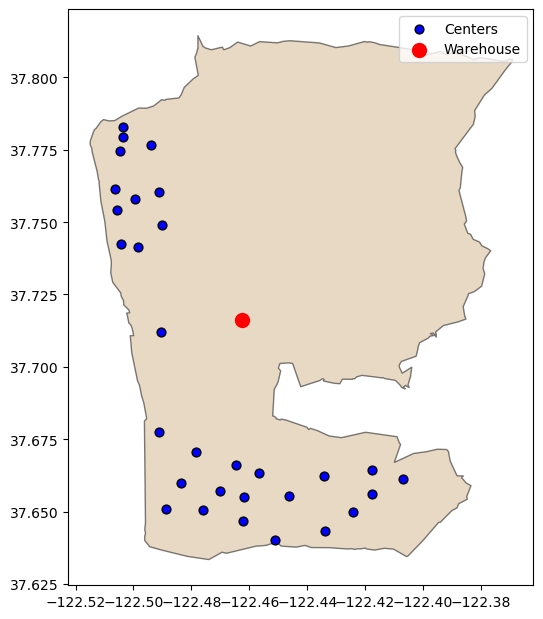

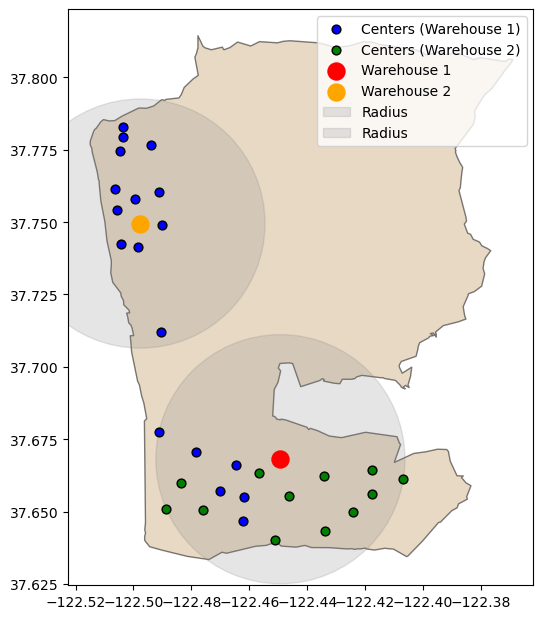

In [54]:
plot_results_on_map_2(
    study_area=map_area, 
    clis=target_demand_points,  
    warehouses_gdf=warehouses_gdf,
    z_value=z_value,
    r = optimal_r  
    )

Склады, похоже, в правильном месте. Но центры раскрасились по принадлежности криво. Ошибку я не успел найти